# Introduction

Defaulting loan is one of the biggest challenges for a loan provider especially for fintech and banking industry. Therefore, it is important to assess the risk of loan applicant accurately to mitigate loses.

Based on the datasets, we can infer the following steps involved in a loan approval process: <br>


1.   Client submits loan application.
2.   After the application is received, client’s information is sent to the underwriters (auto/manual) to detect any possible fraud.
3. Loan application will be approved once the applicant is proven to be genuine and not have track record of defaulting loan.
4. Once the applicant agreed on taking an approved loan, it will be funded.





In this notebook, we will explore the development of a model to predict whether a new applicant is likely to default on their loan repayment. This model will use various features, such as the applicant’s loan amount, previous average payment, lead cost, and other relevant information, to make this prediction. We will start by exploring the data and performing necessary data preprocessing steps such as handling missing values, transforming skewed features, and dealing with imbalanced data. We will then build and train our model using popular machine learning algorithms such as XGBoost and measure the performance using metrics such as AUC-ROC. By the end of this notebook, you will have a solid understand of building this loan repayment model and the steps involved in its development.

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#1. Explonatory Data Analysis (EDA)

Read data from `loan.csv`




In [ ]:
loan = pd.read_csv('./data/loan.csv', parse_dates=['applicationDate', 'originatedDate'])
print("loan.shape:", loan.shape)
loan.head()

loan.shape: (577682, 19)


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


Read data from `clarity_underwriting_variables.csv`

In [ ]:
underwriting = pd.read_csv("./data/clarity_underwriting_variables.csv", low_memory=False)
print("underwriting.shape:", underwriting.shape)
underwriting.head()

underwriting.shape: (49752, 54)


,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
0,8.0,2.0,2.0,2.0,8.0,2.0,2.0,5.0,10.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,A8,match,6.0,871.0,54cbffcee4b0ba763e43144d
1,5.0,2.0,2.0,2.0,11.0,2.0,2.0,4.0,21.0,True,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,397.0,54cc0408e4b0418d9a7f78af
2,9.0,4.0,2.0,3.0,10.0,8.0,2.0,9.0,25.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,572.0,54cc0683e4b0418d9a80adb6
3,3.0,2.0,2.0,2.0,9.0,2.0,2.0,2.0,9.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,838.0,54cc0780e4b0ba763e43b74a
4,5.0,5.0,2.0,2.0,6.0,5.0,2.0,5.0,6.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,768.0,54cc1d67e4b0ba763e445b45


Read data from `payment.csv`. However, it contains information about each loan payment which is not available during prediction. We must be careful when using any information here for our model as it may cause target leakage. Therefore, we cannot directly utilize any information here. Instead, we will need to perform feature engineering and discuss it later in our notebook.

In [ ]:
payment = pd.read_csv('./data/payment.csv',parse_dates=['paymentDate'])
print("payment.shape:", payment.shape)
payment.head()

payment.shape: (689364, 9)


,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19 05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02 05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16 05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30 05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13 05:00:00,43.89,125.72,169.61,Checked,NaN


Combine data and acquire relevant data from `loan.csv` and `clarity_underwriting_variables.csv`

In [ ]:
# Merge loan and underwriting dataframe based on appropriate ID
data = loan.merge(underwriting, left_on='clarityFraudId', right_on='underwritingid', how='left')
# only consider funded loan
data = data[data['isFunded'] == 1]
print("data.shape:", data.shape)
data.head()

data.shape: (38982, 73)


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,NaN,partial,NaN,D04,NaN,NaN,invalid,5.0,879.0,569eb3a3e4b096699f685d64
15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28 19:54:22.982,True,2016-11-29 20:30:40.640,2.0,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01 15:55:41.823,True,2017-03-01 16:15:13.016,0.0,True,1,...,(U) Unlisted,match,NaN,NaN,NaN,NaN,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,(M) Mobile Phone,partial,NaN,NaN,NaN,A8,match,6.0,835.0,58450a15e4b0bb9d6d7344c7
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,(P) Pager,match,NaN,NaN,NaN,NaN,match,1.0,624.0,578f9346e4b0810ad5e7b72e


## 1.1 Define Target Variables

Since our main goal is to predict whether a new applicant is likely to default on their loan repayment. We will inspect `loanStatus` and find all the unique value within it for more clues about our target target.

In [ ]:
# Find the percentage of each unique value in loanStatus
data['loanStatus'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')

Paid Off Loan                  29.31%
External Collection            29.07%
New Loan                       20.81%
Internal Collection            14.27%
Returned Item                   3.03%
Settlement Paid Off             1.82%
Settled Bankruptcy              0.83%
Pending Paid Off                0.43%
Charged Off Paid Off            0.41%
Charged Off                     0.00%
Settlement Pending Paid Off     0.00%
Name: loanStatus, dtype: object

As expected, we found values can be represent whether a loan is defaulted or not.


*  `Settled Bankruptcy` and `Charged off ` can be labeled as defaulted loan.
*  `Paid Off Loan` and `Settlement Paid Off` can be labeled as non defaulted loan.

Then, we can create a new `target` variable representing both cases, making it a binary classification problem.

In [ ]:
# helper function to map loan status to target
# 1 represented defaulted loan, 0 represent non-defaulted loan
def map_target(status):
  hash = {('Settled Bankruptcy','Charged Off'):1,
            ('Paid Off Loan','Settlement Paid Off'):0}
  for key, val in hash.items():
    if status in key:
      return val

# Apply helper function to map loan status to target
data['target'] = data['loanStatus'].map(map_target)
# Drop rows with no target label
data = data[data['target'].notna()].reset_index(drop=True)
print("data.shape:",data.shape)
data.head()

data.shape: (12461, 74)


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid,target
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,partial,NaN,D04,NaN,NaN,invalid,5.0,879.0,569eb3a3e4b096699f685d64,0.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,partial,NaN,NaN,NaN,A8,match,6.0,835.0,58450a15e4b0bb9d6d7344c7,0.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,match,NaN,NaN,NaN,NaN,match,1.0,624.0,578f9346e4b0810ad5e7b72e,0.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,match,NaN,NaN,NaN,NaN,match,1.0,770.0,56621584e4b0100e84141586,0.0
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## 1.2 Preliminary Feature Selection

In this section, we will manually select features for merged dataframe from both `loan.csv` and `clarity_underwriting_dictionary.csv`

Most data `underwriting_dictionary.csv` are related to fraud detection. Our main goal is to predict loan performance instead of fraud detection. <br>
Therefore, we will only use `clearfraudscore` - Although loan default might be somewhat related to fraudulent information, we will only use this feature and assume it is sufficient to identify potential fraud.

The following feature are kept: <br>


*   `loanId` and `anon_ssn`: Unique identifier for each loan entry and applicant. Which is important to perform data preprocessing later.
*   `loanAmount`, `originallyScheduledPaymentAmount` and `apr`: Features related to loan amount which directly affects borrower’s ability to repay them.
*   `payFrequency`: Able to provide insight into a borrower’s ability to make timely payments.
*   `applicationDate` and `originatedDate`: May not provide useful information at first sight, but we will disclose its use in the feature engineering section
*   `nPaidOff`: Provide insight about borrower’s financial responsibility and ability to make payments
*   `leadCost` and `leadType`: Provide insight about lead quality
*   `hasCF` and `clearfraudscore`: Provide information about possible fraud.
*   `target`: What we want to predict, will be dropped during train test split.










In [ ]:
data = data[['loanId',
         'anon_ssn',
         'loanAmount',
         'originallyScheduledPaymentAmount',
         'apr',
         'payFrequency',
         'applicationDate',
         'originatedDate',
         'nPaidOff',
         'leadCost',
         'hasCF',
         'clearfraudscore',
         'leadType',
         'target']]

Now, we try to validate the `nPaidOff` feature by creating a new `n_loan` feature that sums up the amount of loan for each entry before its respective `applicationDate` based on `anon_ssn`.

In [ ]:
count = data[['anon_ssn', 'loanId', 'applicationDate', 'nPaidOff']]
count = count.sort_values(by=['anon_ssn', 'applicationDate'])
count['n_loan'] = count.groupby(['anon_ssn'])['loanId'].cumcount()
count[count['n_loan']!=count['nPaidOff']]

,anon_ssn,loanId,applicationDate,nPaidOff,n_loan
9936,000c0aa9b221e0ca8bb76dfd55d3847c,LL-I-12250877,2016-11-28 15:14:54.192,1.0,0
786,001f12a5ea9b8599964dabac9426b21a,LL-I-18128795,2017-03-08 16:23:44.972,3.0,0
6878,0048392539dd30e0f51693a65018926d,LL-I-08159638,2016-03-27 20:45:07.305,1.0,0
3273,00871911865d987c46dc45f004200ef6,LL-I-04517029,2015-11-11 01:58:58.734,1.0,0
6009,008da4faa95007e182487cfedcb0ced4,LL-I-13058856,2016-12-13 22:16:46.387,4.0,0
...,...,...,...,...,...
5104,ff8f2605f2090c9eb35e6cbcdf5b6e0e,LL-I-12108945,2016-10-20 13:02:34.242,2.0,1
5669,ffa9cf1f21ee06ff8bae7a1c8742ed9d,LL-I-09767638,2016-06-15 12:24:02.604,1.0,0
9133,ffabd93d155d1ad6c21f238b6659716e,LL-I-12177762,2016-11-15 19:37:05.169,2.0,0
12433,ffd2a15f7d9b3009941067cdaa99b30d,LL-I-09508628,2016-06-03 20:50:36.006,1.0,0


Interestingly, we found that some loan entries are missing since some `nPaidOff` > `n_loan`. Logically, the value of `nPaidOff` should be lesser than or greater than the value of `n_loan` when the borrower either paid of all their loans or they still have an ongoing loan repayment.

Therefore, we could conclude that some entry in loan.csv is missing. Making the information from payment.csv less useful because we wouldn't be able to represent the complete payment history for each borrower accurately.

Ideally, we wouldn't want to include `nPaidoff` and any feature related to `payment.csv` file due to discrepancy in data. However, these features helped us model achieved better performance compared to excluding them. So, we will include them in our model for the time being.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12461 entries, 0 to 12460
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            12461 non-null  object        
 1   anon_ssn                          12461 non-null  object        
 2   loanAmount                        12461 non-null  float64       
 3   originallyScheduledPaymentAmount  12461 non-null  float64       
 4   apr                               12461 non-null  float64       
 5   payFrequency                      12461 non-null  object        
 6   applicationDate                   12461 non-null  datetime64[ns]
 7   originatedDate                    12461 non-null  datetime64[ns]
 8   nPaidOff                          12454 non-null  float64       
 9   leadCost                          12461 non-null  int64         
 10  hasCF                             12461 non-nu

# 2.0 Data Preprocessing

##  2.1 Feature Engineering

### Loan to Originally Scheduled Payment Ratio

Based on the selected feature, we can create `Loan_SchedulePay_Ratio`. This feature can be calculated by divinding the loan amount with the originially scheduled payment amount. This could give an indication whether the loan repayment is manageable for the borrower.

In [ ]:
data['Loan_SchedulePay_Ratio'] = data['loanAmount']/data['originallyScheduledPaymentAmount']
data[['Loan_SchedulePay_Ratio', "loanAmount", 'originallyScheduledPaymentAmount']].head()

,Loan_SchedulePay_Ratio,loanAmount,originallyScheduledPaymentAmount
0,0.469103,3000.0,6395.19
1,0.377213,1250.0,3313.78
2,0.328937,800.0,2432.08
3,0.709824,300.0,422.64
4,0.334497,300.0,896.87


### Time taken to originate a loan

Next, we can create `orignateTime` by subtracting the payment application date from the originated date. This could give an indication of the processing time for the loan and whether it was approved quickly or not.

In [ ]:
data['orignateTime'] = (data['originatedDate'] - data['applicationDate']).dt.seconds / (60*60)
data['orignateTime'].head()

0    17.695000
1     0.199167
2     5.949444
3    12.104722
4     1.722222
Name: orignateTime, dtype: float64

Here, we are going to utilize information from `payment.csv`.

1. Using the feature direcly to train our model could cause **target leakage**, making our model inaccurate.
2. For example, if we included `paymentAmount` and `paymentStatus` during training, it would giveaway whether a borrower had actually paid their loan and the amounnt  paid, which defeats the purpose of our model. Moreover, these information shouldn't be available when predicting a new loan application.
3. However, we could still draw useful insights from `payment.csv` by generating historical data. This can be done by creating features that are only available at the time of loan origination.



In [ ]:
# Merge loan.csv and payment.csv based 'loanId'
tmp = pd.merge(loan, payment, on='loanId')
# Only consider funded loans
tmp = tmp[tmp['isFunded']==1]

### CollectScore

We will sum up the occurence of each value from `isCollection` feature. With the following assumption:


1.   Since `isCollection` represent whether the payment is from a custom made collection plan, it could indicate the borrower was delinquent on their payments.
2.   If `isCollection` is **False**, means borrower is more committed to paying off their loan.
3. On the other hand, if `isCollection` is **True**, means borrower is less committed to paying off their loan, leading to higher chance of defaulting a loan.
4. From that, we can create `collectScore` by subtrating the occurence of **False** value from **True** value to represent how deliquent are the borrower on their payments.



In [ ]:
tmp['val'] = 1
tmp.sort_values(by='anon_ssn', inplace=True)

# create a new table, that shows count of each unique value (True, False) from 'isCollection` based on 'anon_ssn','loanId','originatedDate', 'paymentStatus'
pay_history = (tmp
 .pivot_table(index=['anon_ssn','loanId','originatedDate', 'paymentStatus'], columns=['isCollection'] , values='val', aggfunc=sum, fill_value=0)
 .reset_index()
)

pay_history.columns.name = None
pay_history['collectScore'] = pay_history[False] - pay_history[True]
# drop irrelevant columns
pay_history.drop(True, axis=1,inplace=True)
pay_history.drop(False, axis=1, inplace=True)
# show result
pay_history

,anon_ssn,loanId,originatedDate,paymentStatus,collectScore
0,00006b47f484731c95b4c11a42f9c2e3,LL-I-13612582,2016-12-21 03:15:05.820,Cancelled,12
1,00006b47f484731c95b4c11a42f9c2e3,LL-I-13612582,2016-12-21 03:15:05.820,Checked,2
2,00069c6c4fa5fa1b94b845ffde8e081b,LL-I-10308424,2016-07-15 21:15:51.841,Cancelled,2
3,00069c6c4fa5fa1b94b845ffde8e081b,LL-I-10308424,2016-07-15 21:15:51.841,Checked,25
4,00094b88d7a7caea540dd3c77fe1ff9c,LL-I-06339246,2016-01-08 18:40:55.663,Cancelled,11
...,...,...,...,...,...
97994,fffd209b1487bbfa0bac0e0cebdbf3a1,LL-I-07128889,2016-02-08 22:59:16.888,Checked,2
97995,fffd209b1487bbfa0bac0e0cebdbf3a1,LL-I-07128889,2016-02-08 22:59:16.888,Rejected,1
97996,fffd7563fec0c41601731551a9b08e51,LL-I-15750901,2017-01-18 17:30:15.980,Checked,3
97997,fffd7563fec0c41601731551a9b08e51,LL-I-15750901,2017-01-18 17:30:15.980,None,10


### Average payment

Next, we are going to calculate the `averagePayment` for each loan. This feature can provide information on the borrower's payment behavior and and financial stability.

In [ ]:
# Get the average payment value by averaging the 'paymentAmount' based on 'anon_ssn', 'loanId', 'originatedDate', 'paymentStatus'
average_payment = tmp.groupby(['anon_ssn', 'loanId', 'originatedDate', 'paymentStatus'])['paymentAmount'].mean().reset_index()
average_payment.rename(columns={'paymentAmount':'averagePayment'}, inplace=True)

Combine both feature `averagePayment` and `collectScore` in a single table. <br>

We only consider entries with sucessful payments or else those feature wouldn't be valid.

In [ ]:
pay_history = pay_history.merge(average_payment, on=['anon_ssn', 'loanId', 'originatedDate', 'paymentStatus'])
pay_history = pay_history[pay_history['paymentStatus']=="Checked"]

After setting up all the required variables, we can finally create the `cumCollectScore` and `prevAveragePayment` feature with the following definition:

1.   `cumCollectScore`: The historical collection score of a borrower before respective loan origination date.
2.   `prevAveragePayment`: The historical average payment of a borrower before respective loan origination date.



### Getting Cumulative Collection Score and Previous Average Payment

In [ ]:
cumCollectScore = []
prevAvgPayment = []

def get_historical(pay_history):
  for anon_ssn in pay_history['anon_ssn'].unique():
    ssn_df = pay_history[pay_history['anon_ssn']==anon_ssn]

    # running value to get sum of value until ith row
    running_score = 0
    running_total_avg = 0
    count = 0

    # Since 'anon_ssn' is already sorted previously, it helps us ensure to loop through the record from earliest to latest
    for i, row in ssn_df.iterrows():
      # append sum of collect score up until previous row
      cumCollectScore.append(running_score)


      # to handle zero division
      if count == 0:
        prevAvgPayment.append(0)
      # append sum of average payment up until previous row[]
      else:
        prevAvgPayment.append(running_total_avg/count)

      # update running value with sum until current row
      running_score += row['collectScore']
      running_total_avg += row['averagePayment']
      count += 1

  # append new features to dataframe
  pay_history['cumCollectScore']=cumCollectScore
  pay_history['prevAveragePayment']=prevAvgPayment
  # drop irrelevant features
  pay_history.drop('collectScore', axis=1, inplace=True)
  pay_history.drop('averagePayment', axis=1, inplace=True)
  pay_history.drop('originatedDate', axis=1, inplace=True)
  pay_history.drop('paymentStatus', axis=1, inplace=True)
  # save aggregate data as csv file
  pay_history.to_csv('./data/pay_history.csv',index=False)

# get_historical(pay_history)

Read the created `pay_history.csv` file and make sure everything is fine

In [ ]:
pay_history = pd.read_csv('./data/pay_history.csv')
pay_history[pay_history['anon_ssn']=="b8220b6957a50194e6f21b325e4eecb7"]

,anon_ssn,loanId,cumCollectScore,prevAveragePayment
22827,b8220b6957a50194e6f21b325e4eecb7,LL-I-09841500,0,0.000000
22828,b8220b6957a50194e6f21b325e4eecb7,LL-I-10872876,2,656.250000
22829,b8220b6957a50194e6f21b325e4eecb7,LL-I-12099631,6,526.592500
22830,b8220b6957a50194e6f21b325e4eecb7,LL-I-12483650,9,398.943889
22831,b8220b6957a50194e6f21b325e4eecb7,LL-I-13080560,10,456.497917
22832,b8220b6957a50194e6f21b325e4eecb7,LL-I-15426987,12,431.491333
22833,b8220b6957a50194e6f21b325e4eecb7,LL-I-16552936,14,427.052778


Since everything is alright, we will merge the aggregated `pay_history` with our main dataframe `data`.

In [ ]:
# Merge data with pay_history dataframe
data = data.merge(pay_history, on=["anon_ssn","loanId"], how="left")
# Show result
data

,loanId,anon_ssn,loanAmount,originallyScheduledPaymentAmount,apr,payFrequency,applicationDate,originatedDate,nPaidOff,leadCost,hasCF,clearfraudscore,leadType,target,Loan_SchedulePay_Ratio,orignateTime,cumCollectScore,prevAveragePayment
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,3000.0,6395.19,199.0,B,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,0,1,879.0,prescreen,0.0,0.469103,17.695000,0.0,0.000000
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,1250.0,3313.78,490.0,S,2017-01-31 17:48:17.381,2017-01-31 18:00:14.520,2.0,0,1,835.0,organic,0.0,0.377213,0.199167,4.0,392.151667
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,800.0,2432.08,590.0,B,2016-08-27 09:08:05.442,2016-08-29 15:05:04.014,0.0,10,1,624.0,bvMandatory,0.0,0.328937,5.949444,0.0,0.000000
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,300.0,422.64,404.1,W,2016-05-25 03:05:18.849,2016-05-25 15:11:36.260,3.0,0,1,770.0,organic,0.0,0.709824,12.104722,7.0,97.872857
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,300.0,896.87,590.0,W,2015-05-26 17:02:27.312,2015-05-26 18:45:48.024,0.0,6,0,NaN,bvMandatory,0.0,0.334497,1.722222,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456,LL-I-15390953,c81e355845a451b77c29b6515efa2578,1500.0,5111.56,645.0,B,2017-01-16 04:56:31.235,2017-01-16 05:30:10.885,0.0,25,1,925.0,lead,0.0,0.293452,0.560833,0.0,0.000000
12457,LL-I-12367915,55392b05f72f8c3e32e5157612406ba8,600.0,1670.18,565.0,B,2016-12-01 16:57:49.231,2016-12-01 17:28:21.872,3.0,0,0,NaN,rc_returning,0.0,0.359243,0.508889,0.0,0.000000
12458,LL-I-15280684,73690518af906288434b2a0cfd972fe0,375.0,1042.40,645.0,M,2017-01-14 19:43:08.685,2017-01-14 20:00:10.426,0.0,25,1,700.0,lead,0.0,0.359747,0.283611,0.0,0.000000
12459,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,400.0,664.12,449.0,B,2016-06-22 01:10:50.110,2016-06-22 21:46:54.359,0.0,40,1,806.0,lead,0.0,0.602301,20.601111,0.0,0.000000


Finally, we are just going to rearange the columns in `data` so that target is positioned at the last column. We are doing this because we want the correlation value of `target` positioned at the last row/column of the correlated matrix for easier viewing.

In [ ]:
col = list(data.columns)
col.remove('target')
col.append('target')
data = data[col]
data.head()

,loanId,anon_ssn,loanAmount,originallyScheduledPaymentAmount,apr,payFrequency,applicationDate,originatedDate,nPaidOff,leadCost,hasCF,clearfraudscore,leadType,Loan_SchedulePay_Ratio,orignateTime,cumCollectScore,prevAveragePayment,target
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,3000.0,6395.19,199.0,B,2016-01-19 22:07:36.778,2016-01-20 15:49:18.846,0.0,0,1,879.0,prescreen,0.469103,17.695000,0.0,0.000000,0.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,1250.0,3313.78,490.0,S,2017-01-31 17:48:17.381,2017-01-31 18:00:14.520,2.0,0,1,835.0,organic,0.377213,0.199167,4.0,392.151667,0.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,800.0,2432.08,590.0,B,2016-08-27 09:08:05.442,2016-08-29 15:05:04.014,0.0,10,1,624.0,bvMandatory,0.328937,5.949444,0.0,0.000000,0.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,300.0,422.64,404.1,W,2016-05-25 03:05:18.849,2016-05-25 15:11:36.260,3.0,0,1,770.0,organic,0.709824,12.104722,7.0,97.872857,0.0
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,300.0,896.87,590.0,W,2015-05-26 17:02:27.312,2015-05-26 18:45:48.024,0.0,6,0,NaN,bvMandatory,0.334497,1.722222,0.0,0.000000,0.0


## 2.2 Data Visualization

In this section, we are going to generate histogram for each numeric features and have a look at their data distribution

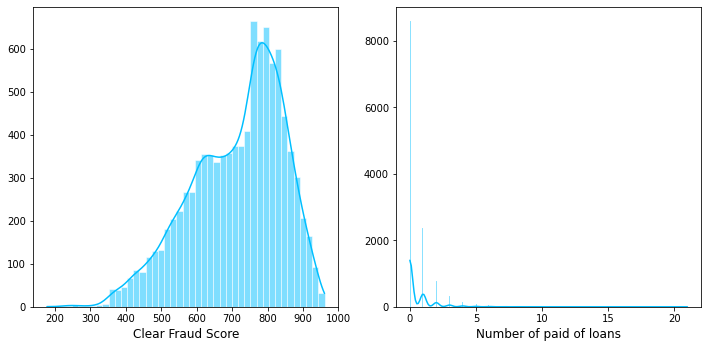

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.set(style="darkgrid")

sns.histplot(data=data, x='clearfraudscore' , kde=True, color="deepskyblue", ax=ax[0])
sns.histplot(data=data, x='nPaidOff' , kde=True, color="deepskyblue", ax=ax[1])


ax[0].set_xlabel('Clear Fraud Score', fontsize=12)
ax[0].set_ylabel('')
ax[1].set_xlabel('Number of paid of loans', fontsize=12)
ax[1].set_ylabel('')

plt.tight_layout()

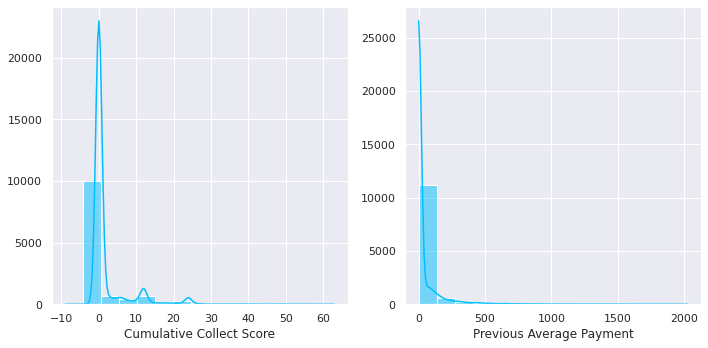

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.set(style="darkgrid")

sns.histplot(data=data, x='cumCollectScore' , kde=True, color="deepskyblue", ax=ax[0])
sns.histplot(data=data, x='prevAveragePayment' , kde=True, color="deepskyblue", ax=ax[1])

ax[0].set_xlabel('Cumulative Collect Score', fontsize=12)
ax[0].set_ylabel('')
ax[1].set_xlabel('Previous Average Payment', fontsize=12)
ax[1].set_ylabel('')

plt.tight_layout()

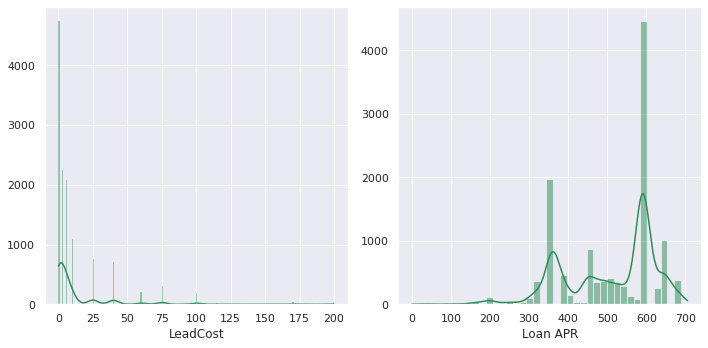

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.set(style="darkgrid")

sns.histplot(data=data, x='leadCost' , kde=True, color="seagreen", ax=ax[0])
sns.histplot(data=data, x='apr' , kde=True, color="seagreen", ax=ax[1])

ax[0].set_xlabel('LeadCost', fontsize=12)
ax[0].set_ylabel('')

ax[1].set_xlabel('Loan APR', fontsize=12)
ax[1].set_ylabel('')

plt.tight_layout()

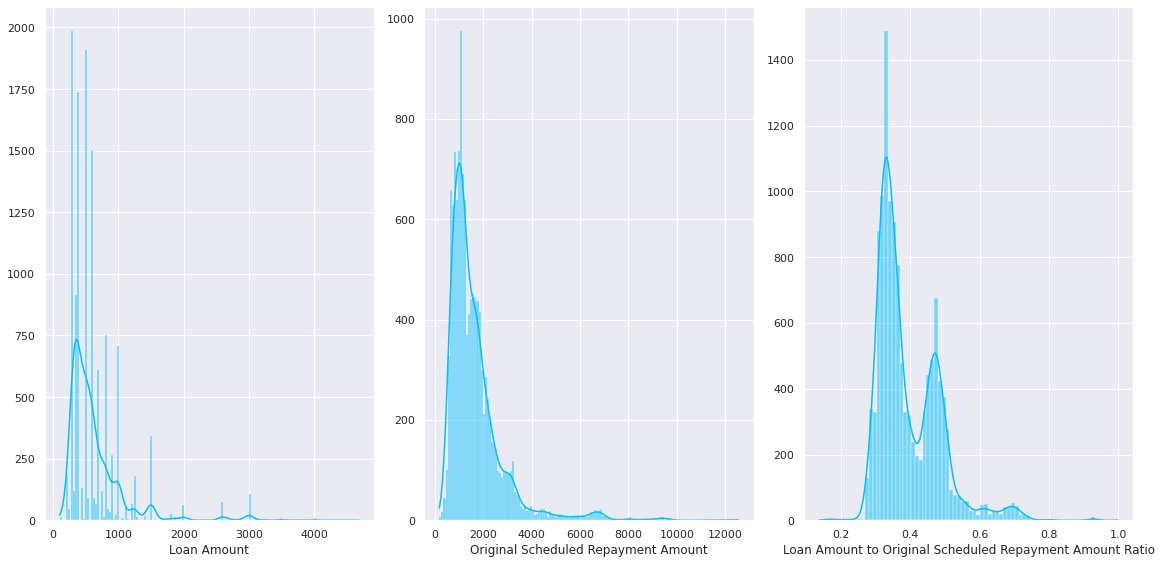

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
sns.set(style="darkgrid")

sns.histplot(data=data, x='loanAmount' , kde=True, color="deepskyblue", ax=ax[0])
sns.histplot(data=data, x='originallyScheduledPaymentAmount' , kde=True, color="deepskyblue", ax=ax[1])
sns.histplot(data=data, x='Loan_SchedulePay_Ratio' , kde=True, color="deepskyblue", ax=ax[2])

ax[0].set_xlabel('Loan Amount', fontsize=12)
ax[0].set_ylabel('')

ax[1].set_xlabel('Original Scheduled Repayment Amount', fontsize=12)
ax[1].set_ylabel('')

ax[2].set_xlabel('Loan Amount to Original Scheduled Repayment Amount Ratio', fontsize=12)
ax[2].set_ylabel('')

plt.tight_layout()

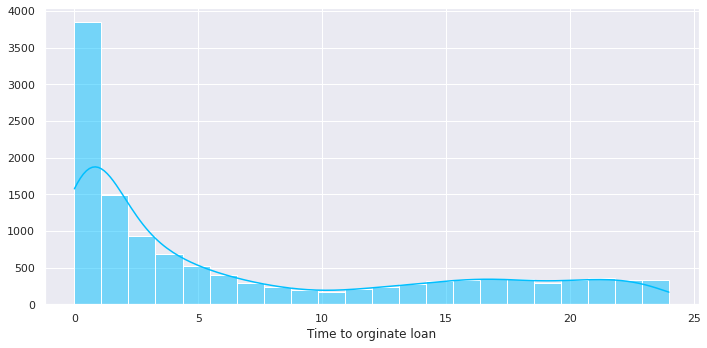

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="darkgrid")

sns.histplot(data=data, x='orignateTime' , kde=True, color="deepskyblue")

ax.set_xlabel('Time to orginate loan', fontsize=12)
ax.set_ylabel('')


plt.tight_layout()

Here, we are going to generate bar chart for each categorical features.

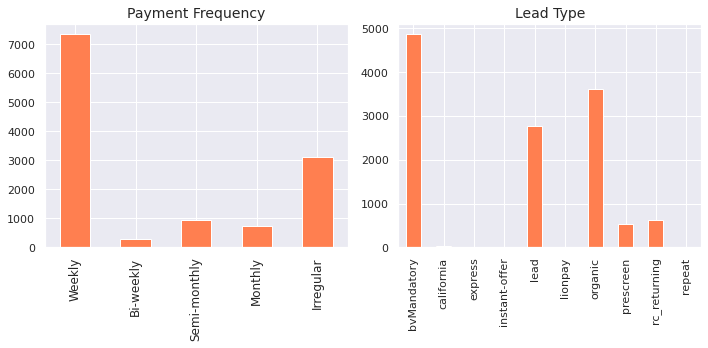

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
data.groupby(['payFrequency']).size().plot(kind='bar', color='coral', ax=ax[0])
data.groupby(['leadType']).size().plot(kind='bar', color='coral', ax=ax[1])

ax[0].set_title('Payment Frequency', fontsize=14)
ax[0].set_xticklabels(['Weekly', 'Bi-weekly', 'Semi-monthly', 'Monthly', 'Irregular'], fontsize=12)
ax[0].set_xlabel('')

ax[1].set_title('Lead Type', fontsize=14)
ax[1].set_xlabel('')

plt.tight_layout()

Upon drawing the bar chart for the `target` label, we found that our data is imbalanced. Majority of entries are non-defaulted loan, which could result in poor performance when trying to predict entries related to the minority class. We will address this issue in the data preprocessing section.

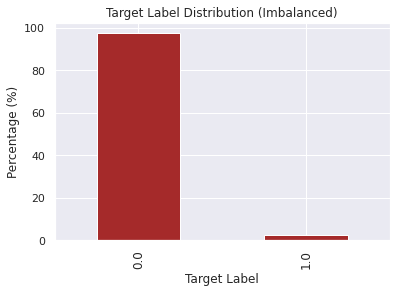

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
data['target'].value_counts(normalize=True).apply(lambda x: round(x * 100, 2)).plot(kind='bar',color='brown')

ax.set_title('Target Label Distribution (Imbalanced)')
ax.set_xticklabels(data['target'].value_counts().index, fontsize=12)
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Target Label')
plt.show()

### Correlation Matrix

<AxesSubplot:>

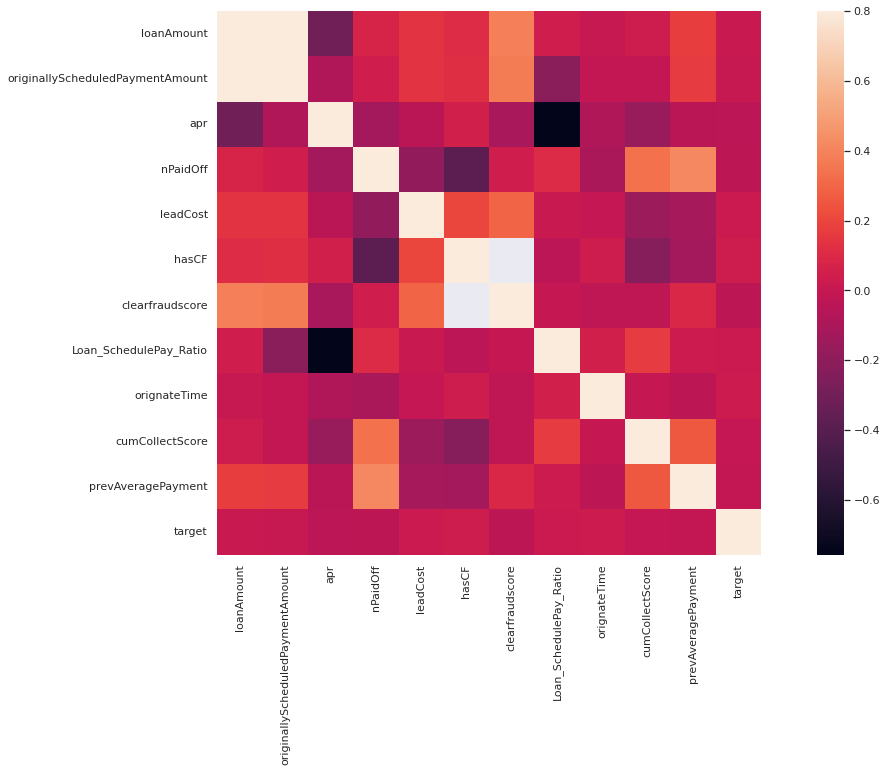

In [ ]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.8, square=True)

From the correlation matrix we found that:


1.   `loanAmount` and `originallyScheduledAmount` are highly correlated, suggesting multicollinearity.
2.   `hasCF` and `clearfraudscore` are highly correlated, suggesting multicollinearity.
3. None of the features are highly correlated with `target`.



## 2.3 Dealing with Missing Data

Next, we are going to check for missing data.

In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
clearfraudscore,2584,0.207367
prevAveragePayment,248,0.019902
cumCollectScore,248,0.019902
nPaidOff,7,0.000562
loanId,0,0.000000


Upon inspection, we found that


1.   Roughly 20% of `clearfraudscore` is missing
2.   Roughly 2% of `cumCollectScore` and `prevAveragePayment` are missing, suggesting these loan is funded to first time borrower. However, 2 of the loan entries does not have any record in payment.csv.
3. 7 rows of `nPaidOff` is missing.



In [ ]:
data_id = data[data['cumCollectScore'].isna()]['loanId'].values
payment_id = payment['loanId'].values
print("Missing entries in payment.csv:")

for id in data_id:
  if id not in payment_id:
    print(id)

Missing entries in payment.csv:
LL-I-18584520
LL-I-18419282


In [ ]:
# fill missing 'clearfraudscore' with median value
data.loc[data['clearfraudscore'].isna(), 'clearfraudscore'] = data['clearfraudscore'].median()
# fill missing 'prevAveragePayment' and 'cumCollectScore' with 0 because they does not have any track record
data.loc[data['prevAveragePayment'].isna(), 'prevAveragePayment'] =0
data.loc[data['cumCollectScore'].isna(), 'cumCollectScore'] = 0
# fill missing 'nPaidOff' with mode value
data.loc[data['nPaidOff'].isna(), 'nPaidOff'] = data['nPaidOff'].mode()[0]

Double check whether there is any missing data left and we are good to go.

## 2.4 Dropping irrelevant features

In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
loanId,0,0.0
anon_ssn,0,0.0
prevAveragePayment,0,0.0
cumCollectScore,0,0.0
orignateTime,0,0.0


In [ ]:
data.drop(['loanId', 'anon_ssn', 'applicationDate','originatedDate','hasCF', 'originallyScheduledPaymentAmount'], axis=1, inplace=True)



1.   We are dropping `loanId`, `anon_ssn`, `applicationDate`, `originatedDate` as it provide no useful information for our model.
2.   Due to multicollinearity, we are dropping `hasCF` and `originallyScheduledPaymentAmount`.


In [ ]:
data.columns

Index(['loanAmount', 'apr', 'payFrequency', 'nPaidOff', 'leadCost',
       'clearfraudscore', 'leadType', 'Loan_SchedulePay_Ratio', 'orignateTime',
       'cumCollectScore', 'prevAveragePayment', 'target'],
      dtype='object')

##  2.5 Dealing with categorical input

We have two categorical features namely `leadType` and `payFrequency`.

1.   `leadType` is nominal (does not have any order), therefore we use one-hot encoding
2.   `payFrequncy` is ordinal (has order; weekly, biweekly, semi-monthly...), therefore we use ordinal encoding.



In [ ]:
# One-hot encoding
data = pd.get_dummies(data, columns=['leadType'])

# Ordinal encoding
data['payFrequency'] = data['payFrequency'].map({
    'W': 0,
    'B': 1,
    'S': 2,
    'M': 3,
    'I': 4
})

data.head()

,loanAmount,apr,payFrequency,nPaidOff,leadCost,clearfraudscore,Loan_SchedulePay_Ratio,orignateTime,cumCollectScore,prevAveragePayment,...,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat
0,3000.0,199.0,1,0.0,0,879.0,0.469103,17.695000,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,0
1,1250.0,490.0,2,2.0,0,835.0,0.377213,0.199167,4.0,392.151667,...,0,0,0,0,0,0,1,0,0,0
2,800.0,590.0,1,0.0,10,624.0,0.328937,5.949444,0.0,0.000000,...,1,0,0,0,0,0,0,0,0,0
3,300.0,404.1,0,3.0,0,770.0,0.709824,12.104722,7.0,97.872857,...,0,0,0,0,0,0,1,0,0,0
4,300.0,590.0,0,0.0,6,742.0,0.334497,1.722222,0.0,0.000000,...,1,0,0,0,0,0,0,0,0,0


After that we are going to perform data transformation for all numerical features to reduce the impact of outliar and prevent one feature from dominating the other.



*   Perform logarithmic transformation for features that are skewed with high range of values; `loanAmount`, `apr`.
*   Perform Box-cox transformation for features that are highly positively skewed; `orignateTime`, `leadCost`, `nPaidOff`.
*   Perform z-score transformation for features which we want to conserve its Gaussianity; `clearfraudscore`.
*   Perform square root transform for features thatare positively skewed, and to compresss their range; `Loan_SchedulePay_Ratio`, `prevAveragePayment`.
*   Perform cube root transform for feature that is contains negative value and is positively skewed; `cumCollectScore`.






In [ ]:
data_before_trans = data.copy()

# log transform
data[['loanAmount', 'apr']] = np.log(data[['loanAmount', 'apr']]+1)

# Box-cox transformation
feats = ['orignateTime', 'leadCost', 'nPaidOff']
for feat in feats:
    data[feat], _ = stats.boxcox(data[feat] + 1)

# z-score
data['clearfraudscore'] = stats.zscore(data['clearfraudscore'])

# square root transform
data[['Loan_SchedulePay_Ratio', 'prevAveragePayment']] = np.sqrt(data[['Loan_SchedulePay_Ratio', 'prevAveragePayment']])

# cube root transform
data['cumCollectScore'] = np.cbrt(data['cumCollectScore'])


In [ ]:
transformed = ['loanAmount', 'apr','orignateTime', 'leadCost', 'nPaidOff', 'clearfraudscore', 'Loan_SchedulePay_Ratio', 'prevAveragePayment', 'cumCollectScore']
data[transformed].describe()

,loanAmount,apr,orignateTime,leadCost,nPaidOff,clearfraudscore,Loan_SchedulePay_Ratio,prevAveragePayment,cumCollectScore
count,12461.000000,12461.000000,12461.000000,12461.000000,12461.000000,1.246100e+04,12461.000000,12461.000000,12461.000000
mean,6.288603,6.200713,1.396005,1.112741,0.108256,2.360683e-16,0.623202,2.353786,0.363737
std,0.519129,0.284191,0.905245,0.975049,0.162153,1.000040e+00,0.068068,5.777014,0.830409
min,4.615121,0.000000,0.000000,0.000000,0.000000,-4.669630e+00,0.370119,0.000000,-2.080084
25%,5.860786,5.968708,0.524981,0.000000,0.000000,-5.569988e-01,0.573154,0.000000,0.000000
50%,6.216606,6.338594,1.340252,1.192430,0.000000,1.915345e-01,0.600376,0.000000,0.000000
75%,6.552508,6.381816,2.353785,1.857130,0.328587,6.389337e-01,0.676340,0.000000,0.000000
max,8.452761,6.560451,2.747909,3.109518,0.398473,2.075774e+00,1.000000,45.042202,3.979057


Plot histogram for all transformed features

Below is the histogram summary before performing data transformation

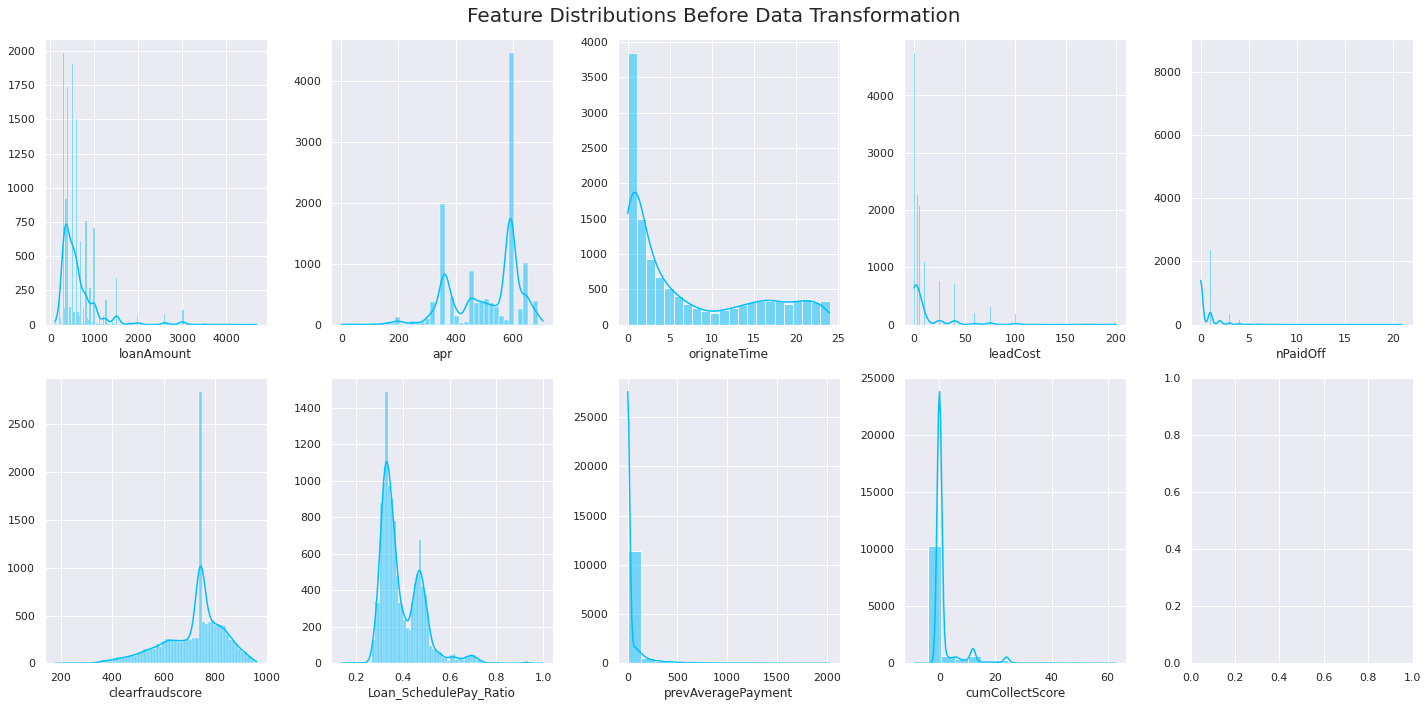

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
sns.set(style="darkgrid")
pos = [[i,j] for i in range(2) for j in range(5)]

for feat,a in zip(transformed,pos):
  sns.histplot(data=data_before_trans, x=feat , kde=True, color="deepskyblue", ax=axs[a[0],a[1]])
  axs[a[0],a[1]].set_ylabel('')

plt.suptitle('Feature Distributions Before Data Transformation', fontsize=20)
plt.tight_layout()

Below is the histogram summary after performing data transformation

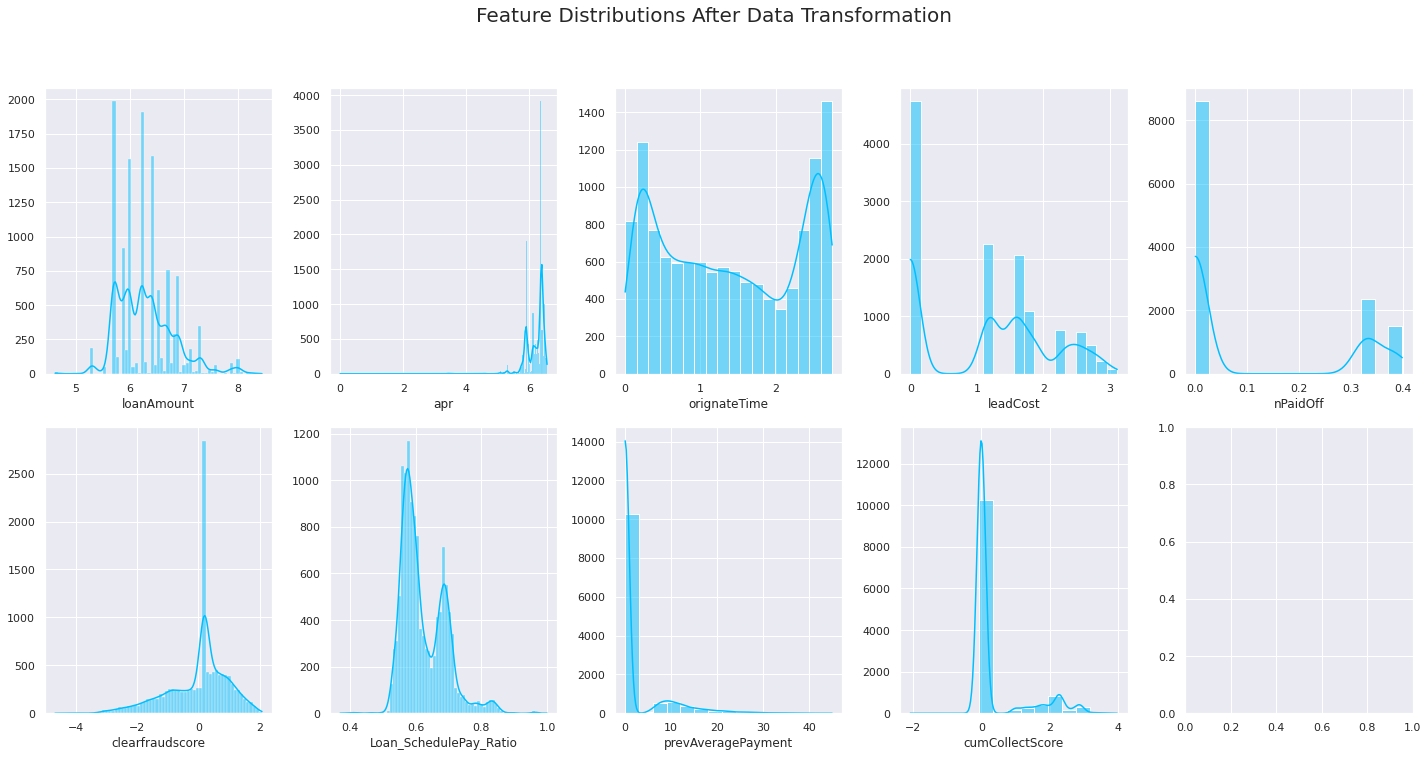

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
sns.set(style="darkgrid")
pos = [[i,j] for i in range(2) for j in range(5)]

for feat,a in zip(transformed,pos):
  sns.histplot(data=data, x=feat , kde=True, color="deepskyblue", ax=axs[a[0],a[1]])
  axs[a[0],a[1]].set_ylabel('')

plt.suptitle('Feature Distributions After Data Transformation', fontsize=20, y=1.05)
plt.tight_layout()

After performing data transformation we notice that all of our features are scaled to a more similar range, appear to be more symmetric, and less skewed.







## 2.6 Dealing with imbalanced data

Since the defaulted samples significantly outnumber the non-defaulted samples. We will perform **SMOTE** to generate synthetic example for the minority class example.

In [ ]:
X_train, y_train = data.drop('target', axis=1, inplace=False), data['target']

print("Class Distribution Percentage before data augmentation:")
print(y_train.value_counts(normalize=True)*100)

# SMOTE
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_resample(X_train, y_train)

print("Class Distribution Percentage afrer data augmentation:")
print(y_train.value_counts(normalize=True)*100)

# split the dataset into 70% train set and 30% test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=7)

Class Distribution Percentage before data augmentation:
0.0    97.383838
1.0     2.616162
Name: target, dtype: float64
Class Distribution Percentage afrer data augmentation:
0.0    50.0
1.0    50.0
Name: target, dtype: float64


In [ ]:
data.columns

Index(['loanAmount', 'apr', 'payFrequency', 'nPaidOff', 'leadCost',
       'clearfraudscore', 'Loan_SchedulePay_Ratio', 'orignateTime',
       'cumCollectScore', 'prevAveragePayment', 'target',
       'leadType_bvMandatory', 'leadType_california', 'leadType_express',
       'leadType_instant-offer', 'leadType_lead', 'leadType_lionpay',
       'leadType_organic', 'leadType_prescreen', 'leadType_rc_returning',
       'leadType_repeat'],
      dtype='object')

# 3.0 Model

We have a selected **XGBoost** as our prediction model as it is robust to skewness. Furthermore, we will use **ROC-AUC** score rather than accuracy as our evaluation metric due to data imbalance

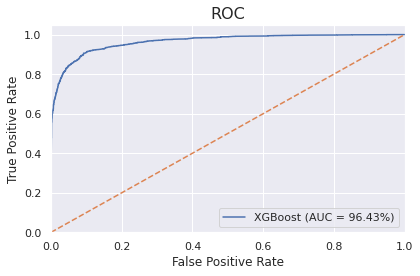

In [ ]:
# Train an XGBoost model
model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)

clf = model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = model.predict_proba(X_train)[:, 1]
y_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC graph
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred) * 100:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', fontsize=16)
plt.legend(loc='lower right')
plt.tight_layout()

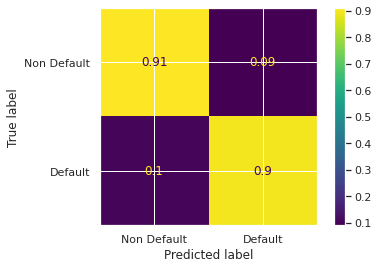

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
predicted = model.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, predicted)
confusion_matrix = confusion_matrix/np.sum(confusion_matrix,axis=1).reshape(-1,1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Non Default', 'Default'])
# plt.grid(False)


# plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=False, title='Normalized confusion matrix')

cm_display.plot()
plt.savefig('./confusion.png', format='png')
plt.show()

In [ ]:
print(confusion_matrix/np.sum(confusion_matrix,axis=1).reshape(-1,1))

[[0.91038925 0.08961075]
 [0.1032345  0.8967655 ]]


Finally, our model is able to achieve ROC-AUC score of 96.34%.

## 3.1 Evaluate feature importance

Based on the feature importance graph below, we found that `nPaidOff` plays the most important role in our model. Which make sense because borrowers that have less track record of paying off loan is more likely to default.

Up next, `loanAmount` and `apr` also significantly impact the prediction of our model because they directly affect the borrower's ability to repay the loan. Additionally, `loanAmount` could also indicate a borrower's financial stability.

`leadCost` also impact the prediction of our model significantly as it is placed 4th in feature importance. This could due to the lead quality in which higher `leadCost` represent better lead quality, therefore the borrower has more creditworthiness. On the other hand, not all `leadType` help with the prediction of our model.

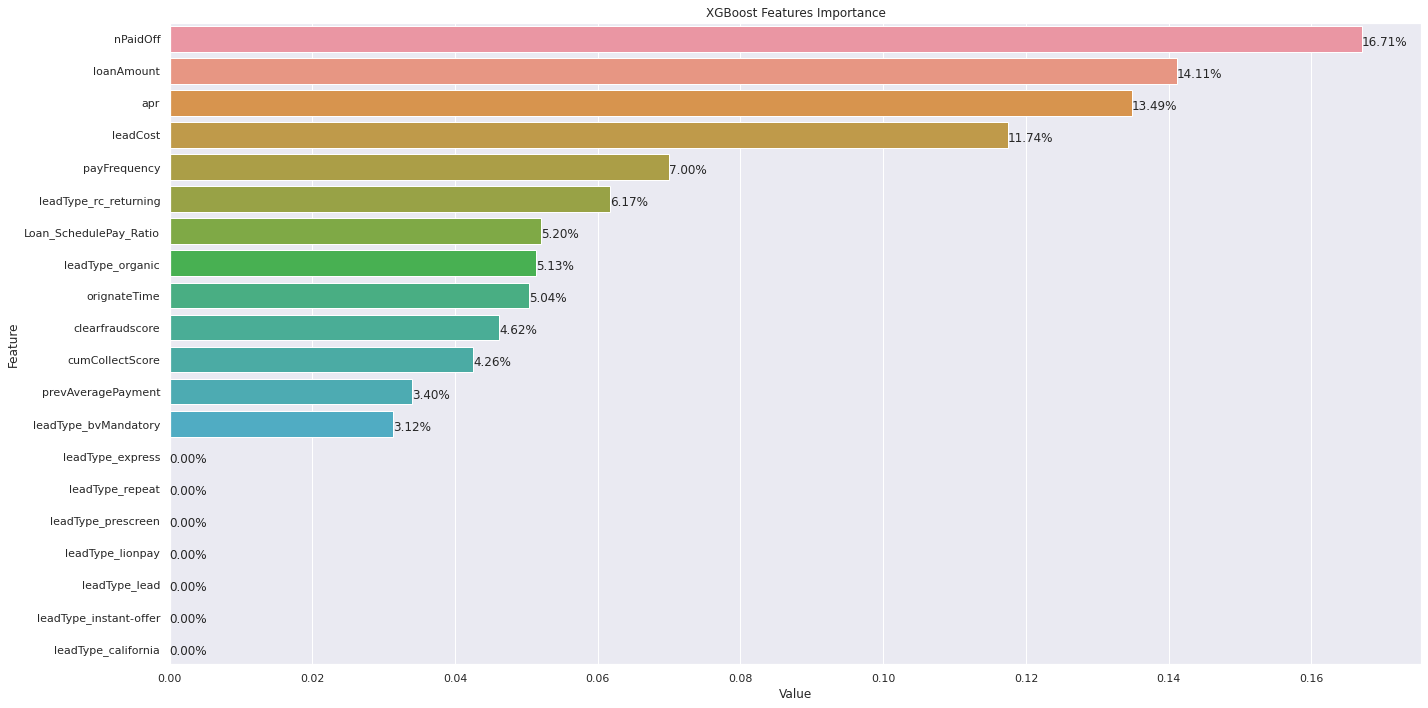

In [ ]:
clf_imp = clf.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(clf_imp,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
for i, v in enumerate(clf_imp[np.argsort(clf_imp)[::-1]]):
    plt.text(v, i + 0.2, f'{v * 100:.2f}%')
plt.title("XGBoost Features Importance")
plt.savefig('./feat.png', format='png')
plt.tight_layout()

# 4.0 Conclusion

In conclusion, we have developed a loan repayment model using XGBoost algorithm that predicts the likelihood of a borrower to default on their loan repayment. Our model utilizes several important features such as loan amount, pay frequency, credit score, and past repayment history to make accurate predictions. We have also performed data preprocessing techniques such as data imputation, data transformation, and data balancing to improve the performance of our model.

The final model achieved an ROC AUC score of 96.34% on the test set, which indicates that our model has a good ability to distinguish between the positive and negative classes. The model can be used by lenders to assess the risk associated with lending money to a particular borrower and make informed decisions based on the predictions made by the model.

It is important to note that the model is not perfect and there may be instances where it makes incorrect predictions. Therefore, it should be used as a tool to supplement the decision-making process rather than a replacement for human judgement. Overall, our loan repayment model is a valuable tool for lenders to assess risk and make informed decisions when lending money.

## 4.1 Suggestion

1. To improve the model's performance, we could gather features such as:
  *   Income: Reflect borrower's ability to repay the loan
  *   Debt: Provide insights into borrower's ability financial situation and ability to repay the loan
  *   Credit Score: Provide insights into borrower's creditworth. Borrowers with higher credit score is more likely to repay the loan
  *   Employment History: Provide information about borrower's current and previous jobs. Borrowers with stable employment history is more likely to repay the loan.
  *   Education level and age: Borrowers with higher education level or older may be less risky as they are likely to have higher income and stability.

2. Retrieve the missing entries for `loan.csv`. It would be difficult to keep track of borrower's historical data accurately without a complete record.


